# Finformer

NOTE: Should values in the batch be correlated by time? Test same-window batch with random tickers and random window batch with random tickers.

In [ ]:
!pwd

/content


In [ ]:
%cd /content

/content


In [ ]:
!git clone https://github.com/halaction/finformer.git

fatal: destination path 'finformer' already exists and is not an empty directory.


In [ ]:
%cd /content/finformer

/content/finformer


In [ ]:
!git reset --hard
!git pull

HEAD is now at d5ec1a3 fix: configs opt
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Total 6 (delta 5), reused 6 (delta 5), pack-reused 0
Unpacking objects: 100% (6/6), 495 bytes | 247.00 KiB/s, done.
From https://github.com/halaction/finformer
   d5ec1a3..3e217ee  main       -> origin/main
Updating d5ec1a3..3e217ee
Fast-forward
 finformer/configs/training_args/full.yaml | 10 +++++-----
 1 file changed, 5 insertions(+), 5 deletions(-)


# Setup

In [ ]:
!pip install transformers
!pip install transformers[torch]
!pip install accelerate -U
!pip install peft
!pip install evaluate
!pip install torchinfo
!pip install hydra-core
!pip install wandb

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
from tqdm.auto import tqdm

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchinfo import summary

from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
from google.colab import userdata


HF_TOKEN = userdata.get('HF_TOKEN')
WANDB_API_KEY = userdata.get('WANDB_API_KEY')

In [ ]:
os.environ["HF_TOKEN"] = HF_TOKEN

os.environ["WANDB_API_KEY"] = WANDB_API_KEY
os.environ["WANDB_PROJECT"] = 'finformer'
os.environ["WANDB_LOG_MODEL"] = 'checkpoint'

In [ ]:
from huggingface_hub import login, hf_hub_download

login(token=HF_TOKEN)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
import wandb

wandb.login(key=WANDB_API_KEY)

wandb: Currently logged in as: halaction. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Trainer

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!git reset --hard
!git pull

HEAD is now at 3e217ee fix: config
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0
Unpacking objects: 100% (5/5), 401 bytes | 200.00 KiB/s, done.
From https://github.com/halaction/finformer
   3e217ee..8f3ed07  main       -> origin/main
Updating 3e217ee..8f3ed07
Fast-forward
 finformer/data/data.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from finformer.config import get_config
from finformer.data.dataset import get_split_dataset
from finformer.seq2seq_trainer import FinformerSeq2SeqTrainer

In [ ]:
from transformers import set_seed


set_seed(0)

## Config

In [ ]:
config = get_config(
    overrides=[
        'params=full',
        'params.min_news=1000',
        'params.max_lag=1',
        'params.batch_size=16',
        'params.mask_sentiment=true',

        'features=univariate_diff',

        'training_args=full',
        'training_args.fp16=false',
        'training_args.gradient_accumulation_steps=4',
        'training_args.gradient_checkpointing=false',
        'training_args.auto_find_batch_size=false',
        'training_args.output_dir=trainer/tst-base-univariate-diff-bert-tiny',
        'training_args.run_name=tst-base-univariate-diff-mean-bert-tiny',
        'training_args.log_level=debug',
        'training_args.num_train_epochs=5',
        'training_args.logging_steps=50',
        'training_args.save_strategy=steps',
        'training_args.save_steps=0.1',
        'training_args.evaluation_strategy=steps',
        'training_args.eval_steps=0.1',

        'sentiment_model=tiny',
        'sentiment_model.training_type=lora',
        'sentiment_model.max_batch_size=32',

        'time_series_model=base',
        'time_series_model.model.config.scaling=null',
        'time_series_model.model.config.distribution_output=student_t',
    ]
)

In [ ]:
config

{'dirs': {'data_dir': './data', 'source_dir': './finformer', 'source_data_dir': './finformer/data', 'source_model_dir': './finformer/model', 'fmp_dir': './data/fmp', 'raw_dataset_dir': './data/raw-dataset', 'dataset_dir': './data/dataset'}, 'hf': {'dataset_dir': 'raw-dataset', 'repo_id': 'halaction/finformer-data'}, 'fmp': {'metrics': {'dir': './data/fmp/metrics', 'separate': True, 'endpoint': 'v3/key-metrics', 'path_params': {'symbol': None}, 'query_params': {'apikey': None, 'limit': None, 'period': None}}, 'news': {'dir': './data/fmp/news', 'separate': True, 'endpoint': 'v3/stock_news', 'path_params': None, 'query_params': {'apikey': None, 'limit': None, 'page': None, 'tickers': None}}, 'prices': {'dir': './data/fmp/prices', 'separate': True, 'endpoint': 'v3/historical-price-full', 'path_params': {'symbol': None}, 'query_params': {'apikey': None, 'from': None, 'serietype': None, 'to': None}}, 'profile': {'dir': './data/fmp/profile', 'separate': False, 'endpoint': 'v3/profile', 'path_

## Init

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
train_dataset, val_dataset, test_dataset = get_split_dataset(config, force=False)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--prajjwal1--bert-tiny/snapshots/6f75de8b60a9f8a2fdf7b69cbd86d9e64bcb3837/config.json
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embeddi

In [ ]:
trainer = FinformerSeq2SeqTrainer(
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    config=config,
)

Generate config GenerationConfig {}

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--prajjwal1--bert-tiny/snapshots/6f75de8b60a9f8a2fdf7b69cbd86d9e64bcb3837/config.json
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--prajjwal1--bert-tiny/snapshots/6f75de8b60a9f8a2fdf7b69cbd86d9e64bcb3837/pytorch_model.bin
Some weights of the model checkp

trainable params: 25,680 || all params: 4,420,896 || trainable%: 0.5808777225250266


In [ ]:
trainer.model.from_pretrained('halaction/finformer-model')

config.json:   0%|          | 0.00/152 [00:00<?, ?B/s]

AttributeError: 'NoneType' object has no attribute 'from_pretrained'

In [ ]:
summary(trainer.model)

Layer (type:depth-idx)                                                                Param #
FinformerModel                                                                        --
├─SentimentModel: 1-1                                                                 --
│    └─PeftModelForSequenceClassification: 2-1                                        --
│    │    └─LoraModel: 3-1                                                            4,420,896
├─TimeSeriesModel: 1-2                                                                --
│    └─TimeSeriesTransformerForPrediction: 2-2                                        --
│    │    └─TimeSeriesTransformerModel: 3-2                                           882,784
│    │    └─ParameterProjection: 3-3                                                  6,579
Total params: 5,310,259
Trainable params: 903,523
Non-trainable params: 4,406,736

## Train

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
train_output = trainer.train()

Currently training with a batch size of: 16
***** Running training *****
  Num examples = 10,956
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 855
  Number of trainable parameters = 903,523
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


KeyError: "None of [Index(['change_percent'], dtype='object')] are in the [columns]"

In [ ]:
train_output = trainer.train()

Currently training with a batch size of: 16
***** Running training *****
  Num examples = 10,956
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 855
  Number of trainable parameters = 903,523
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss,Mape/close,Smape/close
86,-10.695800,-15.670873,0.093304,0.087605
172,-27.244600,-34.088524,0.053470,0.053587
258,-32.429600,-42.437325,0.052234,0.051132
344,-36.576400,-47.015129,0.061774,0.063932
430,-40.624000,-55.858074,0.048260,0.048375
516,-47.089100,-55.320889,0.047236,0.047180
602,-51.354100,-56.899632,0.050255,0.048986
688,-54.031600,-57.196316,0.047518,0.046851
774,-56.226800,-67.376289,0.046701,0.046446


***** Running Evaluation *****
  Num examples = 792
  Batch size = 64
Saving model checkpoint to trainer/tst-base-univariate-bert-tiny/checkpoint-86
Configuration saved in trainer/tst-base-univariate-bert-tiny/checkpoint-86/config.json
Configuration saved in trainer/tst-base-univariate-bert-tiny/checkpoint-86/generation_config.json
Model weights saved in trainer/tst-base-univariate-bert-tiny/checkpoint-86/model.safetensors
Logging checkpoint artifacts in checkpoint-86. ...
wandb: Adding directory to artifact (./trainer/tst-base-univariate-bert-tiny/checkpoint-86)... Done. 0.1s
***** Running Evaluation *****
  Num examples = 792
  Batch size = 64
Saving model checkpoint to trainer/tst-base-univariate-bert-tiny/checkpoint-172
Configuration saved in trainer/tst-base-univariate-bert-tiny/checkpoint-172/config.json
Configuration saved in trainer/tst-base-univariate-bert-tiny/checkpoint-172/generation_config.json
Model weights saved in trainer/tst-base-univariate-bert-tiny/checkpoint-172/mod

## Eval

In [ ]:
eval_output = trainer.evaluate(test_dataset)

***** Running Evaluation *****
  Num examples = 1716
  Batch size = 64


In [ ]:
eval_output

{'eval_loss': -38.11955261230469,
 'eval_mape/close': 0.05244444128492335,
 'eval_mape/volume': 0.3247602911197962,
 'eval_smape/close': 0.05247257119301525,
 'eval_smape/volume': 0.3087398949460709,
 'eval_mse/changePercent': 1.568530756462866,
 'eval_mae/changePercent': 0.7563036826973274,
 'eval_runtime': 130.9456,
 'eval_samples_per_second': 13.105,
 'eval_steps_per_second': 0.206,
 'epoch': 4.985754985754986}

## Predict

In [ ]:
pred_output = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 1716
  Batch size = 64


In [ ]:
torch.save(pred_output, 'prediction_output_univariate.pt')

In [ ]:
a = torch.load('prediction_output.pt')

In [ ]:
trainer = FinformerTrainer(config)

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


  0%|          | 0/7 [00:00<?, ?it/s]

raw-dataset/tickers.csv:   0%|          | 0.00/56.8k [00:00<?, ?B/s]

raw-dataset/changes.csv:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

raw-dataset/profile.csv:   0%|          | 0.00/951k [00:00<?, ?B/s]

raw-dataset/metrics.csv:   0%|          | 0.00/58.1M [00:00<?, ?B/s]

raw-dataset/prices.csv:   0%|          | 0.00/195M [00:00<?, ?B/s]

raw-dataset/news.csv:   0%|          | 0.00/322M [00:00<?, ?B/s]

  0%|          | 0/7 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
from finformer.trainer import MetricsCallback

callback = MetricsCallback(trainer)
trainer.add_callback(callback)

You are adding a <class 'finformer.trainer.MetricsCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
TensorBoardCallback
NotebookProgressCallback
MetricsCallback


EvaluationModule(name: "mase", module_type: "metric", features: {'predictions': Value(dtype='float32', id=None), 'references': Value(dtype='float32', id=None)}, usage: """
Args:
    predictions: array-like of shape (n_samples,) or (n_samples, n_outputs)
        Estimated target values.
    references: array-like of shape (n_samples,) or (n_samples, n_outputs)
        Ground truth (correct) target values.
    training: array-like of shape (n_train_samples,) or (n_train_samples, n_outputs)
        In sample training data for naive forecast.
    periodicity: int, default=1
        Seasonal periodicity of training data.
    sample_weight: array-like of shape (n_samples,), default=None
        Sample weights.
    multioutput: {"raw_values", "uniform_average"} or array-like of shape (n_outputs,), default="uniform_average"
        Defines aggregating of multiple output values. Array-like value defines weights used to average errors.

                 "raw_values" : Returns a full set of error

In [ ]:
dataset_train, dataset_val, dataset_test = get_split_dataset(config)

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--ProsusAI--finbert/snapshots/4556d13015211d73dccd3fdd39d39232506f3e43/config.json
Model config BertConfig {
  "_name_or_path": "ProsusAI/finbert",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "positive",
    "1": "negative",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 1,
    "neutral": 2,
    "positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522


0.052631578947368425
0.055555555555555566


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--ProsusAI--finbert/snapshots/4556d13015211d73dccd3fdd39d39232506f3e43/config.json
Model config BertConfig {
  "_name_or_path": "ProsusAI/finbert",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "positive",
    "1": "negative",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 1,
    "neutral": 2,
    "positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522


In [ ]:
eval_prediction = trainer.predict(dataset_test)

***** Running Prediction *****
  Num examples = 888
  Batch size = 4


Step,Training Loss
50,5.618800


Step,Training Loss
50,5.618800


In [ ]:
eval_prediction.metrics

{'test_runtime': 236.2814,
 'test_samples_per_second': 3.758,
 'test_steps_per_second': 0.94}

In [ ]:
from transformers import Trainer, TrainingArguments

In [ ]:
from finformer.utils import FinformerConfig
from finformer.data.dataset import FinformerDataset, FinformerCollator, get_dataloader, get_split_dataset
from finformer.model import FinformerModel
from finformer.utils import get_device

In [ ]:
config = FinformerConfig()

In [ ]:
config.params.lr = 3e-4
config.params.weight_decay = 1e-2

In [ ]:
dataset_train, dataset_val, dataset_test = get_split_dataset(config, test_size=0.2, val_size=0.1)
data_collator = FinformerCollator(config)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--ProsusAI--finbert/snapshots/4556d13015211d73dccd3fdd39d39232506f3e43/config.json
Model config BertConfig {
  "_name_or_path": "ProsusAI/finbert",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "positive",
    "1": "negative",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 1,
    "neutral": 2,
    "positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522


In [ ]:
len(dataset_train.index), len(dataset_val.index), len(dataset_test.index)

(10656, 1332, 3108)

In [ ]:
device = get_device()

device

device(type='cuda')

In [ ]:
model = FinformerModel(config).to(device)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
model = FinformerModel(config)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--ProsusAI--finbert/snapshots/4556d13015211d73dccd3fdd39d39232506f3e43/config.json
Model config BertConfig {
  "_name_or_path": "ProsusAI/finbert",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "positive",
    "1": "negative",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 1,
    "neutral": 2,
    "positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522


In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
training_args = TrainingArguments(
    output_dir='output_dir',
    learning_rate=2e-5,
    per_device_train_batch_size=config.params.batch_size,
    per_device_eval_batch_size=config.params.batch_size,
    num_train_epochs=2,
    weight_decay=0.01,
    log_level='debug',
    logging_steps=10,
    #load_best_model_at_end=True,
    #push_to_hub=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    data_collator=data_collator,
    #compute_metrics=compute_metrics
)

trainer.train()

Currently training with a batch size of: 4
***** Running training *****
  Num examples = 10,656
  Num Epochs = 2
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 5,328
  Number of trainable parameters = 109,614,947


Step,Training Loss
10,6.747100
20,6.659400
30,6.625400
40,6.567900
50,6.430100
60,6.397300
70,6.294300
80,6.284700
90,6.178100
100,6.075400


KeyboardInterrupt: 

In [ ]:
prediction = trainer.predict(dataset_test)

***** Running Prediction *****
  Num examples = 3108
  Batch size = 4


Step,Training Loss
10,6.747100
20,6.659400
30,6.625400
40,6.567900
50,6.430100
60,6.397300
70,6.294300
80,6.284700
90,6.178100
100,6.075400


UnboundLocalError: local variable 'output' referenced before assignment

In [ ]:
prediction

In [ ]:
training_args = TrainingArguments(
    output_dir='output_dir',
    learning_rate=3e-4,
    per_device_train_batch_size=config.params.batch_size,
    per_device_eval_batch_size=config.params.batch_size,
    num_train_epochs=2,
    weight_decay=0.01,
    log_level='debug',
    #load_best_model_at_end=True,
    #push_to_hub=True,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    data_collator=data_collator,
    #compute_metrics=compute_metrics
)

trainer.train()

# Draft

# Data

In [ ]:
data = trainer.get_train_dataloader().dataset.data

In [ ]:
data

In [ ]:
data.prices

open     close       low      high     volume
ticker date                                                         
A      2020-01-01  4.464758  4.465333  4.456670  4.469923  14.146628
       2020-01-02  4.464758  4.465333  4.456670  4.469923  14.146628
       2020-01-03  4.450503  4.449335  4.448516  4.458177  13.927341
       2020-01-04  4.450503  4.449335  4.448516  4.458177  13.927341
       2020-01-05  4.450503  4.449335  4.448516  4.458177  13.927341
...                     ...       ...       ...       ...        ...
ZS     2024-04-11  5.227734  5.224563  5.214283  5.229610  13.931773
       2024-04-12  5.212160  5.206257  5.200815  5.219653  14.002453
       2024-04-13  5.212160  5.206257  5.200815  5.219653  14.002453
       2024-04-14  5.212160  5.206257  5.200815  5.219653  14.002453
       2024-04-15  5.208010  5.169631  5.163299  5.208119  14.634288

[633068 rows x 5 columns]

In [ ]:
data.prices.loc[pd.IndexSlice[('A', 'AAPL'), '2020-01-01'], :]

,,open,close,low,high,volume
ticker,date,,,,,
A,2020-01-01,4.464758,4.465333,4.456670,4.469923,14.146628
AAPL,2020-01-01,4.318288,4.331917,4.314818,4.332705,18.724338


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='date', ylabel='close'>

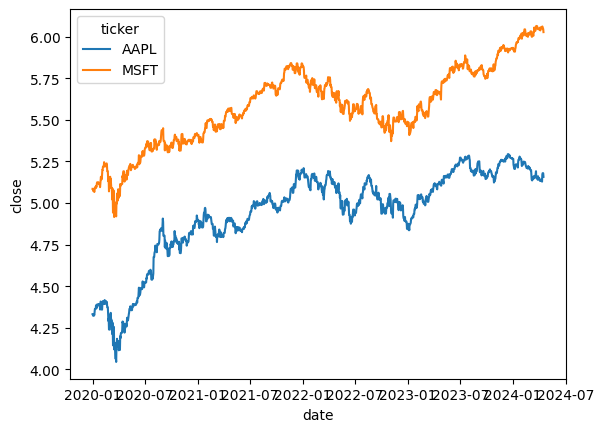

In [ ]:
close_price = data.prices.loc[pd.IndexSlice[('AAPL', 'MSFT'), :], :].reset_index()

sns.lineplot(x='date', y='close', hue='ticker', data=close_price)

In [ ]:
sectors = [
    'Basic Materials',
    'Communication Services',
    'Consumer Cyclical',
    'Consumer Defensive',
    'Energy',
    'Financial Services',
    'Healthcare',
    'Industrials',
    'Real Estate',
    'Technology',
    'Utilities'
]

industries = [
    'Steel',
    'Silver',
    'Other Precious Metals',
    'Gold',
    'Copper',
    'Aluminum',
    'Paper, Lumber & Forest Products',
    'Industrial Materials',
    'Construction Materials',
    'Chemicals - Specialty',
    'Chemicals',
    'Agricultural Inputs',
    'Telecommunications Services',
    'Internet Content & Information',
    'Publishing',
    'Broadcasting',
    'Advertising Agencies',
    'Entertainment',
    'Travel Lodging',
    'Travel Services',
    'Specialty Retail',
    'Luxury Goods',
    'Home Improvement',
    'Residential Construction',
    'Department Stores',
    'Personal Products & Services',
    'Leisure',
    'Gambling, Resorts & Casinos',
    'Furnishings, Fixtures & Appliances',
    'Restaurants',
    'Auto - Parts',
    'Auto - Manufacturers',
    'Auto - Recreational Vehicles',
    'Auto - Dealerships',
    'Apparel - Retail',
    'Apparel - Manufacturers',
    'Apparel - Footwear & Accessories',
    'Packaging & Containers',
    'Tobacco',
    'Grocery Stores',
    'Discount Stores',
    'Household & Personal Products',
    'Packaged Foods',
    'Food Distribution',
    'Food Confectioners',
    'Agricultural Farm Products',
    'Education & Training Services',
    'Beverages - Wineries & Distilleries',
    'Beverages - Non-Alcoholic',
    'Beverages - Alcoholic',
    'Uranium',
    'Solar',
    'Oil & Gas Refining & Marketing',
    'Oil & Gas Midstream',
    'Oil & Gas Integrated',
    'Oil & Gas Exploration & Production',
    'Oil & Gas Equipment & Services',
    'Oil & Gas Energy',
    'Oil & Gas Drilling',
    'Coal',
    'Shell Companies',
    'Investment - Banking & Investment Services',
    'Insurance - Specialty',
    'Insurance - Reinsurance',
    'Insurance - Property & Casualty',
    'Insurance - Life',
    'Insurance - Diversified',
    'Insurance - Brokers',
    'Financial - Mortgages',
    'Financial - Diversified',
    'Financial - Data & Stock Exchanges',
    'Financial - Credit Services',
    'Financial - Conglomerates',
    'Financial - Capital Markets',
    'Banks - Regional',
    'Banks - Diversified',
    'Banks',
    'Asset Management',
    'Asset Management - Bonds',
    'Asset Management - Income',
    'Asset Management - Leveraged',
    'Asset Management - Cryptocurrency',
    'Asset Management - Global',
    'Medical - Specialties',
    'Medical - Pharmaceuticals',
    'Medical - Instruments & Supplies',
    'Medical - Healthcare Plans',
    'Medical - Healthcare Information Services',
    'Medical - Equipment & Services',
    'Medical - Distribution',
    'Medical - Diagnostics & Research',
    'Medical - Devices',
    'Medical - Care Facilities',
    'Drug Manufacturers - Specialty & Generic',
    'Drug Manufacturers - General',
    'Biotechnology',
    'Waste Management',
    'Trucking',
    'Railroads',
    'Aerospace & Defense',
    'Marine Shipping',
    'Integrated Freight & Logistics',
    'Airlines, Airports & Air Services',
    'General Transportation',
    'Manufacturing - Tools & Accessories',
    'Manufacturing - Textiles',
    'Manufacturing - Miscellaneous',
    'Manufacturing - Metal Fabrication',
    'Industrial - Distribution',
    'Industrial - Specialties',
    'Industrial - Pollution & Treatment Controls',
    'Environmental Services',
    'Industrial - Machinery',
    'Industrial - Infrastructure Operations',
    'Industrial - Capital Goods',
    'Consulting Services',
    'Business Equipment & Supplies',
    'Staffing & Employment Services',
    'Rental & Leasing Services',
    'Engineering & Construction',
    'Security & Protection Services',
    'Specialty Business Services',
    'Construction',
    'Conglomerates',
    'Electrical Equipment & Parts',
    'Agricultural - Machinery',
    'Agricultural - Commodities/Milling',
    'REIT - Specialty',
    'REIT - Retail',
    'REIT - Residential',
    'REIT - Office',
    'REIT - Mortgage',
    'REIT - Industrial',
    'REIT - Hotel & Motel',
    'REIT - Healthcare Facilities',
    'REIT - Diversified',
    'Real Estate - Services',
    'Real Estate - Diversified',
    'Real Estate - Development',
    'Real Estate - General',
    'Information Technology Services',
    'Hardware, Equipment & Parts',
    'Computer Hardware',
    'Electronic Gaming & Multimedia',
    'Software - Services',
    'Software - Infrastructure',
    'Software - Application',
    'Semiconductors',
    'Media & Entertainment',
    'Communication Equipment',
    'Technology Distributors',
    'Consumer Electronics',
    'Renewable Utilities',
    'Regulated Water',
    'Regulated Gas',
    'Regulated Electric',
    'Independent Power Producers',
    'Diversified Utilities',
    'General Utilities',
]

In [ ]:
df = df_metrics[df_metrics['date'] >= '2020-01-01']

columns = [
    'revenuePerShare',
    'netIncomePerShare',
    'operatingCashFlowPerShare',
    'freeCashFlowPerShare',
    'cashPerShare',
    'bookValuePerShare',
    'tangibleBookValuePerShare',
    'shareholdersEquityPerShare',
    'interestDebtPerShare',
    'marketCap',
    'enterpriseValue',
    'peRatio',
    'priceToSalesRatio',
    'pocfratio',
    'pfcfRatio',
    'pbRatio',
    'ptbRatio',
    'evToSales',
    'enterpriseValueOverEBITDA',
    'evToOperatingCashFlow',
    'evToFreeCashFlow',
    'earningsYield',
    'freeCashFlowYield',
    'debtToEquity',
    'debtToAssets',
    'netDebtToEBITDA',
    'currentRatio',
    'interestCoverage',
    'incomeQuality',
    'dividendYield',
    'payoutRatio',
    'salesGeneralAndAdministrativeToRevenue',
    'researchAndDdevelopementToRevenue',
    'intangiblesToTotalAssets',
    'capexToOperatingCashFlow',
    'capexToRevenue',
    'capexToDepreciation',
    'stockBasedCompensationToRevenue',
    'grahamNumber',
    'roic',
    'returnOnTangibleAssets',
    'grahamNetNet',
    'workingCapital',
    'tangibleAssetValue',
    'netCurrentAssetValue',
    'investedCapital',
    'averageReceivables',
    'averagePayables',
    'averageInventory',
    'daysSalesOutstanding',
    'daysPayablesOutstanding',
    'daysOfInventoryOnHand',
    'receivablesTurnover',
    'payablesTurnover',
    'inventoryTurnover',
    'roe',
    'capexPerShare'
]

df

,symbol,date,calendarYear,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
0,A,2024-01-31,2024,Q1,5.658703,1.187713,1.655290,1.348123,5.965870,21.119454,...,453000000.0,1.032000e+09,70.295537,58.953020,124.791946,1.280309,1.526639,0.721200,0.056238,-0.307167
1,A,2023-10-31,2023,Q4,5.780822,1.626712,1.767123,1.479452,5.445205,20.017123,...,435000000.0,1.051500e+09,68.832938,48.667529,120.038810,1.307514,1.849282,0.749758,0.081266,-0.287671
2,A,2023-07-31,2023,Q3,5.687075,0.377551,1.911565,1.636054,4.520408,18.904762,...,465500000.0,1.087500e+09,72.075359,40.118343,95.147929,1.248693,2.243363,0.945896,0.019971,-0.275510
3,A,2023-04-30,2023,Q2,5.800676,1.020270,1.344595,1.152027,3.969595,19.530405,...,509500000.0,1.107000e+09,73.436226,54.363178,125.182850,1.225553,1.655532,0.718948,0.052240,-0.192568
4,A,2023-01-31,2023,Q1,5.932432,1.189189,1.000000,0.743243,4.246622,18.949324,...,560000000.0,1.074500e+09,74.777904,61.675127,126.890863,1.203564,1.459259,0.709271,0.062756,-0.256757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61726,ZTS,2021-03-31,2021,Q1,3.934805,1.175605,0.841220,0.679285,7.575184,8.599369,...,401500000.0,1.664000e+09,54.115446,56.721311,278.688525,1.663111,1.586705,0.322941,0.136708,-0.161935
61727,ZTS,2020-12-31,2020,Q4,3.800210,0.754995,1.509989,1.207150,7.575184,7.926393,...,407000000.0,1.627000e+09,50.453791,68.435940,243.793677,1.783810,1.315098,0.369165,0.095251,-0.302839
61728,ZTS,2020-09-30,2020,Q3,3.756046,1.007361,1.181914,0.919033,7.684543,7.575184,...,346000000.0,1.605000e+09,50.996641,58.846154,268.021978,1.764822,1.529412,0.335793,0.132982,-0.262881
61729,ZTS,2020-06-30,2020,Q2,3.256890,0.793183,0.921523,0.732169,7.054492,6.273932,...,300000000.0,1.532500e+09,57.209302,66.851441,316.097561,1.573171,1.346269,0.284722,0.126425,-0.189354


In [ ]:
(df.isna().any() == False).index.tolist()

['symbol',
 'date',
 'calendarYear',
 'period',
 'revenuePerShare',
 'netIncomePerShare',
 'operatingCashFlowPerShare',
 'freeCashFlowPerShare',
 'cashPerShare',
 'bookValuePerShare',
 'tangibleBookValuePerShare',
 'shareholdersEquityPerShare',
 'interestDebtPerShare',
 'marketCap',
 'enterpriseValue',
 'peRatio',
 'priceToSalesRatio',
 'pocfratio',
 'pfcfRatio',
 'pbRatio',
 'ptbRatio',
 'evToSales',
 'enterpriseValueOverEBITDA',
 'evToOperatingCashFlow',
 'evToFreeCashFlow',
 'earningsYield',
 'freeCashFlowYield',
 'debtToEquity',
 'debtToAssets',
 'netDebtToEBITDA',
 'currentRatio',
 'interestCoverage',
 'incomeQuality',
 'dividendYield',
 'payoutRatio',
 'salesGeneralAndAdministrativeToRevenue',
 'researchAndDdevelopementToRevenue',
 'intangiblesToTotalAssets',
 'capexToOperatingCashFlow',
 'capexToRevenue',
 'capexToDepreciation',
 'stockBasedCompensationToRevenue',
 'grahamNumber',
 'roic',
 'returnOnTangibleAssets',
 'grahamNetNet',
 'workingCapital',
 'tangibleAssetValue',
 'ne

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8330 entries, 0 to 61730
Data columns (total 61 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   symbol                                  8330 non-null   object 
 1   date                                    8330 non-null   object 
 2   calendarYear                            8330 non-null   int64  
 3   period                                  8330 non-null   object 
 4   revenuePerShare                         8330 non-null   float64
 5   netIncomePerShare                       8330 non-null   float64
 6   operatingCashFlowPerShare               8326 non-null   float64
 7   freeCashFlowPerShare                    8326 non-null   float64
 8   cashPerShare                            8320 non-null   float64
 9   bookValuePerShare                       8320 non-null   float64
 10  tangibleBookValuePerShare               8320 non-null   float64


<Axes: xlabel='title', ylabel='Count'>

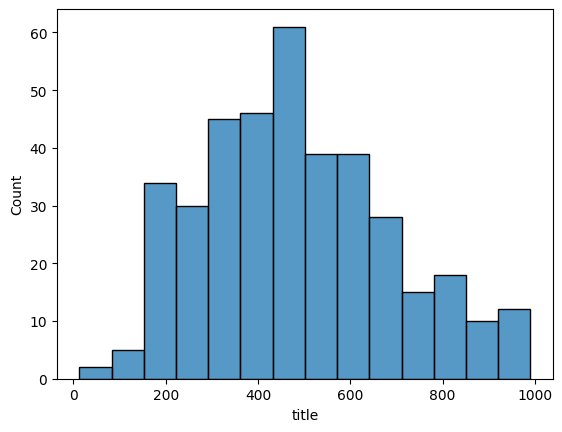

In [ ]:
import seaborn as sns


sns.histplot(news_count[news_count < 1000])

<Axes: xlabel='title', ylabel='Count'>

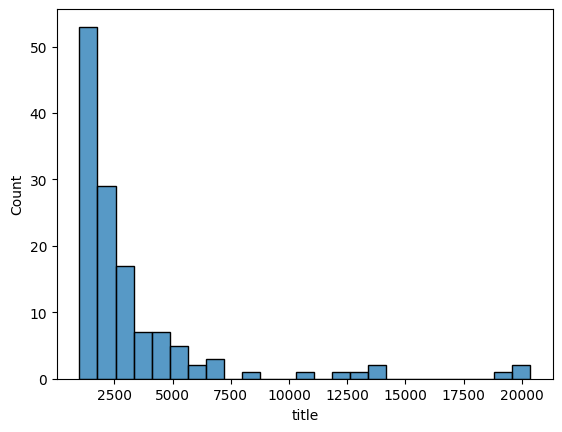

In [ ]:
sns.histplot(news_count[news_count > 1000])

In [ ]:
news_count[news_count < 300].shape

(72,)

<Axes: xlabel='title', ylabel='Count'>

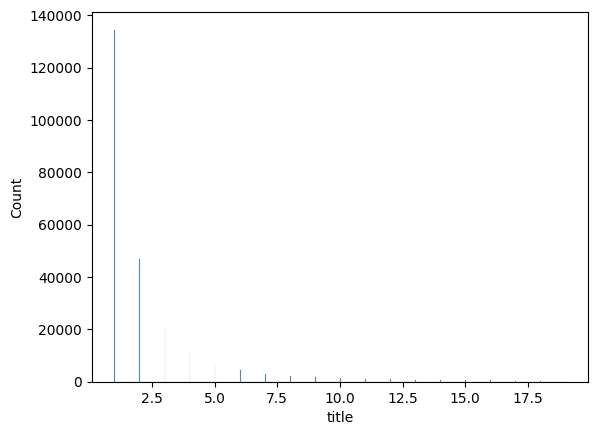

In [ ]:
sns.histplot(news_daily_count[news_daily_count < 20])

In [ ]:
features = dict()

# Profile
features['static_categorical_features'] = ['symbol', 'industry', 'sector', 'country']
features['static_real_features'] = ['age_ipo', ]

# Metrics
features['dynamic_real_features'] = [
    'revenuePerShare',
    'netIncomePerShare',
    'marketCap',
    'peRatio',
    'priceToSalesRatio',
    'pocfratio',
    'pfcfRatio',
    'pbRatio',
    'ptbRatio',
    'debtToEquity',
    'debtToAssets',
    'currentRatio',
    'interestCoverage',
    'incomeQuality',
    'salesGeneralAndAdministrativeToRevenue',
    'researchAndDdevelopementToRevenue',
    'intangiblesToTotalAssets',
    'capexToOperatingCashFlow',
    'capexToDepreciation',
    'investedCapital',
]

# News
features['value_features'] = [
    'open',
    'close',
    'low',
    'high',
    'volume'
]

# Calendar
features['time_features'] = [
    'days_in_month',
    'is_month_end',
    'is_quarter_end',
    'age',
    'weekday_Monday',
    'weekday_Saturday',
    'weekday_Sunday',
    'weekday_Thursday',
    'weekday_Tuesday',
    'weekday_Wednesday',
    'month_August',
    'month_December',
    'month_February',
    'month_January',
    'month_July',
    'month_June',
    'month_March',
    'month_May',
    'month_November',
    'month_October',
    'month_September',
    'quarter_2',
    'quarter_3',
    'quarter_4',
]

import yaml

with open('features.yaml', 'w') as file:
    yaml.dump(features, file)